<a href="https://colab.research.google.com/github/Gabor132/QuarantineSportsClassifier/blob/master/src/QuarantineSportsLSTMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quarantine Sports Classifier 

In [0]:
#
# KERAS2ONNX installation
#
# !pip install -U git+https://github.com/microsoft/onnxconverter-common
# !pip install -U git+https://github.com/onnx/keras-onnx

## Imports

In [120]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import os
os.environ['TF_KERAS'] = '1'
import keras2onnx
from os import listdir
from os.path import isfile, join

IN_COLAB = False
try:
    import google.colab

    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running on local machine")

print("Using tensorflow version {}".format(tf.__version__))
print("Using keras2onnx version {}. Make sure it is 1.7.0".format(keras2onnx.__version__))

Running on Google Colab
Using tensorflow version 2.2.0
Using keras2onnx version 1.7.0. Make sure it is 1.7.0


## Constants

In [121]:
learning_rate = 0.01
testing_data_percentage = 0.2
nr_of_frames_per_sequence = 15
nr_of_keypoints = 25
nr_of_values_per_keypoint = 3

# Dataset paths
DRAGOS_COLAB_DATASET_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/"
LOCAL_DATASET_PATH = "../datasets/"

# Model paths
DRAGOS_COLAB_MODEL_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Model/"
LOCAL_MODEL_PATH = "../"

current_dataset_path = DRAGOS_COLAB_DATASET_PATH if IN_COLAB else LOCAL_DATASET_PATH
current_model_path = DRAGOS_COLAB_MODEL_PATH if IN_COLAB else LOCAL_MODEL_PATH

# Get all file names
all_files_names = [f for f in listdir(current_dataset_path) if isfile(join(current_dataset_path, f)) and f.endswith('.json')]
print("Following dataset files have been found: {}".format(all_files_names))

Following dataset files have been found: ['dragos_no_pushups_2.json', 'dragos_no_pushups.json', 'dimi_no_pushups.json', 'dimi_7_pushups_front_left.json', 'dimi_8_pushups_front_right_2.json', 'dimi_8_pushups_front_right.json', 'dimi_breakdancing.json', 'dragos_13_pushups_front_right.json', 'gakku_10_pushups_back_left.json', 'EDITED-52_geschnitten1of3.json', 'EDITED-24_geschnitten3of3.json', 'EDITED-24_geschnitten2of3.json', 'EDITED-24_geschnitten1of3.json']


In [122]:
dataset_paths = []
for path in all_files_names:
  dataset_path = current_dataset_path + path
  dataset_paths.append(dataset_path)

print("All files found: {}".format(dataset_paths))

All files found: ['/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dragos_no_pushups_2.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dragos_no_pushups.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_no_pushups.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_7_pushups_front_left.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_8_pushups_front_right_2.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_8_pushups_front_right.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_breakdancing.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dragos_13_pushups_front_right.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/gakku_10_pushups_back_left.json', '/content/drive/My Drive/QuarantineSportsD

## Load Datasets and create X and Y

## Important to know

1.   Out of open pose we extract for all frames all the 25 keypoints (each keypoint contains the X, Y and score)
2.   The Category exists per frame and is 0/1 as in Wrong/Correct as in Not a Push-Up Frame/Is a Push Up Frame


In [123]:
y_total = None
x_total = None
for (index, path) in enumerate(dataset_paths):
  print("For file at {}".format(path))
  df = pd.read_json(path)
  keypoints = df['Keypoints'].values
  file_y = df['Category'].values
  file_x = []
  for k in keypoints:
      if k != None:
          newK = np.reshape(np.asarray(k), (25,3))
          file_x.append(newK)
      else:
          file_x.append(np.reshape(np.zeros(75), (25,3)))
  file_x = np.array(file_x)
  print("X: {} and Y: {}".format(file_x.shape, file_y.shape))
  if np.all(x_total == None):
    x_total = file_x
  else:
    x_total = np.vstack((x_total, file_x))
  if np.all(y_total == None):
    y_total = file_y
  else:
    y_total = np.hstack((y_total, file_y))
print("Total X: {}".format(x_total.shape))
print("Total Y: {}".format(y_total.shape))

For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dragos_no_pushups_2.json
X: (140, 25, 3) and Y: (140,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dragos_no_pushups.json
X: (270, 25, 3) and Y: (270,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_no_pushups.json
X: (641, 25, 3) and Y: (641,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_7_pushups_front_left.json
X: (596, 25, 3) and Y: (596,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_8_pushups_front_right_2.json
X: (566, 25, 3) and Y: (566,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_8_pushups_front_right.json
X: (596, 25, 3) and Y: (596,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/dimi_breakdancing.json
X: (686, 25, 3) and Y: (686,)
For fi

In [124]:
categories = np.unique(y_total)
print("Existing categories {}".format(categories))

Existing categories [0 1 2 3]


## Splitting the dataset into categories (wrong and correct)

In [125]:
data_by_category = {}
for category in categories:
  # Get Indexes
  y_category_indexes = np.where(y_total == category)
  # Get Values
  x_category = x_total[y_category_indexes]
  data_by_category.update({category: x_category})
  print("Category {} has {} elements".format(category, len(x_category)))


Category 0 has 4507 elements
Category 1 has 1713 elements
Category 2 has 826 elements
Category 3 has 531 elements


## Remove any frames that only contain empty keypoints

In [126]:

# Check if there are any frames with no keypoints
empty_frame = np.zeros((25, 3))
for category in data_by_category.keys():
    x = data_by_category[category]
    empty_frame_indexes = []
    for index, x_value in enumerate(x):
        if np.array_equal(x_value, empty_frame):
            empty_frame_indexes.append(index)
    print("Category {} has {} empty frames to delete".format(category, len(empty_frame_indexes)))
    x = np.delete(x, empty_frame_indexes, axis=0)
    data_by_category.update({category: x})


Category 0 has 880 empty frames to delete
Category 1 has 156 empty frames to delete
Category 2 has 6 empty frames to delete
Category 3 has 133 empty frames to delete


## Finally, split them into training and testing datasets

In [127]:

def split_dataset_categories(dataset_dict):
    x_train_total = None
    x_test_total = None
    x_validate_total = None
    y_train_total = None
    y_test_total = None
    y_validate_total = None
    for aux_category in dataset_dict.keys():
        x = dataset_dict[aux_category]
        y = to_categorical(np.ones((x.shape[0], 1)) * aux_category, 4)
        aux_x_train, aux_x_test, aux_y_train, aux_y_test = train_test_split(x, y, test_size=0.2)
        aux_x_train, aux_x_validate, aux_y_train, aux_y_validate = train_test_split(aux_x_train, aux_y_train, test_size=0.2)
        if x_train_total is None:
            x_train_total = aux_x_train
            x_test_total = aux_x_test
            x_validate_total = aux_x_validate
            y_train_total = aux_y_train
            y_test_total = aux_y_test
            y_validate_total = aux_y_validate
        else:
            x_train_total = np.concatenate((x_train_total, aux_x_train), axis=0)
            x_test_total = np.concatenate((x_test_total, aux_x_test), axis=0)
            x_validate_total = np.concatenate((x_validate_total, aux_x_validate), axis=0)
            y_train_total = np.concatenate((y_train_total, aux_y_train), axis=0)
            y_test_total = np.concatenate((y_test_total, aux_y_test), axis=0)
            y_validate_total = np.concatenate((y_validate_total, aux_y_validate), axis=0)
    return x_train_total, x_test_total, x_validate_total, y_train_total, y_test_total, y_validate_total



x_train, x_test, x_validate, y_train, y_test, y_validate = split_dataset_categories(data_by_category)
print("Number of training frame sets {} and number of testing frame sets {} and validation frame sets {}".format(len(x_train), len(x_test), len(x_validate)))

Number of training frame sets 4094 and number of testing frame sets 1282 and validation frame sets 1026


## Defining the Model

Model: "QuarantineSportsLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 75)                23700     
_________________________________________________________________
re_lu_16 (ReLU)              (None, 75)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 304       
_________________________________________________________________
softmax_17 (Softmax)         (None, 4)                 0         
Total params: 24,004
Trainable params: 24,004
Non-trainable params: 0
_________________________________________________________________


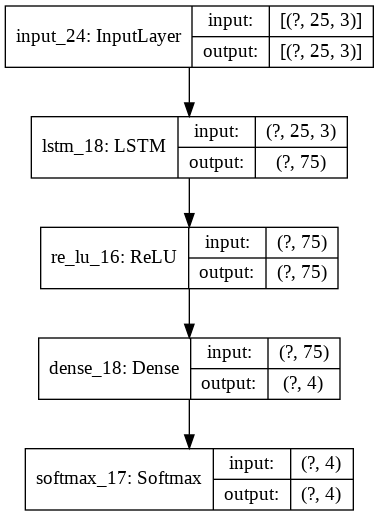

In [128]:
model = tf.keras.Sequential(layers=[
                                    tf.keras.Input(shape=(25, 3)),
                                    tf.keras.layers.LSTM(units=75, recurrent_dropout=0.2),
                                    tf.keras.layers.ReLU(),
                                    tf.keras.layers.Dense(categories.shape[0]),
                                    tf.keras.layers.Softmax(1)
], name="QuarantineSportsLSTM")
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_crossentropy])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training Model


# Training
Epoch 1/100
82/82 [==============================] - 3s 39ms/step - loss: 0.9759 - categorical_crossentropy: 0.9759 - val_loss: 0.8432 - val_categorical_crossentropy: 0.8432
Epoch 2/100
82/82 [==============================] - 3s 36ms/step - loss: 0.7918 - categorical_crossentropy: 0.7918 - val_loss: 0.7998 - val_categorical_crossentropy: 0.7998
Epoch 3/100
82/82 [==============================] - 3s 36ms/step - loss: 0.7080 - categorical_crossentropy: 0.7080 - val_loss: 0.6502 - val_categorical_crossentropy: 0.6502
Epoch 4/100
82/82 [==============================] - 3s 36ms/step - loss: 0.6418 - categorical_crossentropy: 0.6418 - val_loss: 0.6823 - val_categorical_crossentropy: 0.6823
Epoch 5/100
82/82 [==============================] - 3s 36ms/step - loss: 0.5874 - categorical_crossentropy: 0.5874 - val_loss: 0.5892 - val_categorical_crossentropy: 0.5892
Epoch 6/100
82/82 [==============================] - 3s 36ms/step - loss: 0.5507 - categorical_crossentropy: 0.5507 - 

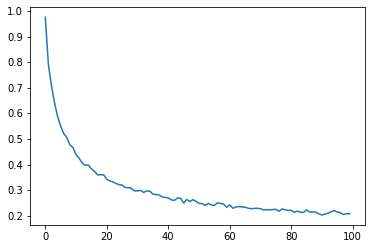

In [129]:

# Training
print("\n# Training")
history = model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=1, validation_data=(x_validate, y_validate))
plt.plot(history.history['loss'])
plt.show()

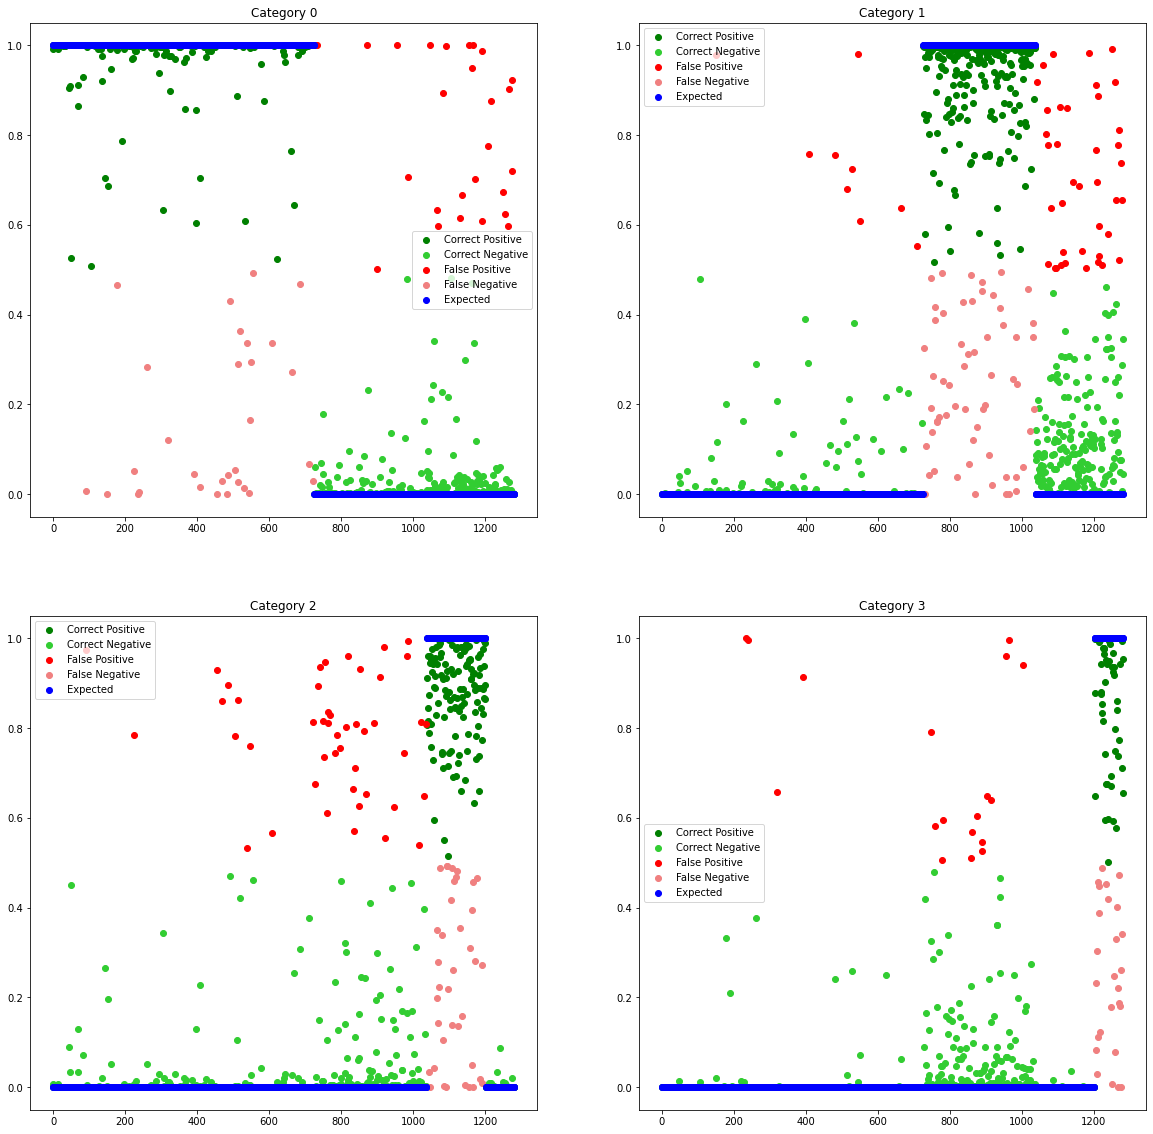

In [133]:
results = model.predict(x_test)

plt.figure(0, figsize=(20, 20))
for i in categories:
  result = results[:, i]
  plt.subplot(2, 2, i+1)
  all_index = range(len(result))
  correct_positive = np.where(result >= 0.5)[0]
  correct_positive = np.intersect1d(correct_positive, np.where(y_test[:, i] == 1)[0])
  correct_negative = np.where(result < 0.5)[0]
  correct_negative = np.intersect1d(correct_negative, np.where(y_test[:, i] != 1)[0])
  false_positive = np.where(result >= 0.5)[0]
  false_positive = np.intersect1d(false_positive, np.where(y_test[:, i] != 1)[0])
  false_negative = np.where(result < 0.5)[0]
  false_negative = np.intersect1d(false_negative, np.where(y_test[:, i] == 1)[0])
  plt.scatter(correct_positive, results[:,i][correct_positive], c='g')
  plt.scatter(correct_negative, results[:,i][correct_negative], c='limegreen')
  plt.scatter(false_positive, results[:,i][false_positive], c='r')
  plt.scatter(false_negative, results[:,i][false_negative], c='lightcoral')
  plt.scatter(range(len(result)), y_test[:, i], c='b')
  plt.legend(["Correct Positive", "Correct Negative",  "False Positive", "False Negative", "Expected"])
  plt.title("Category " + str(i))
plt.show()

In [134]:
print('\n# Evaluate')
result = model.evaluate(x_test, y_test, batch_size=1, verbose=1)


# Evaluate
1282/1282 [==============================] - 5s 4ms/step - loss: 0.3416 - categorical_crossentropy: 0.3416


Total tested 1282


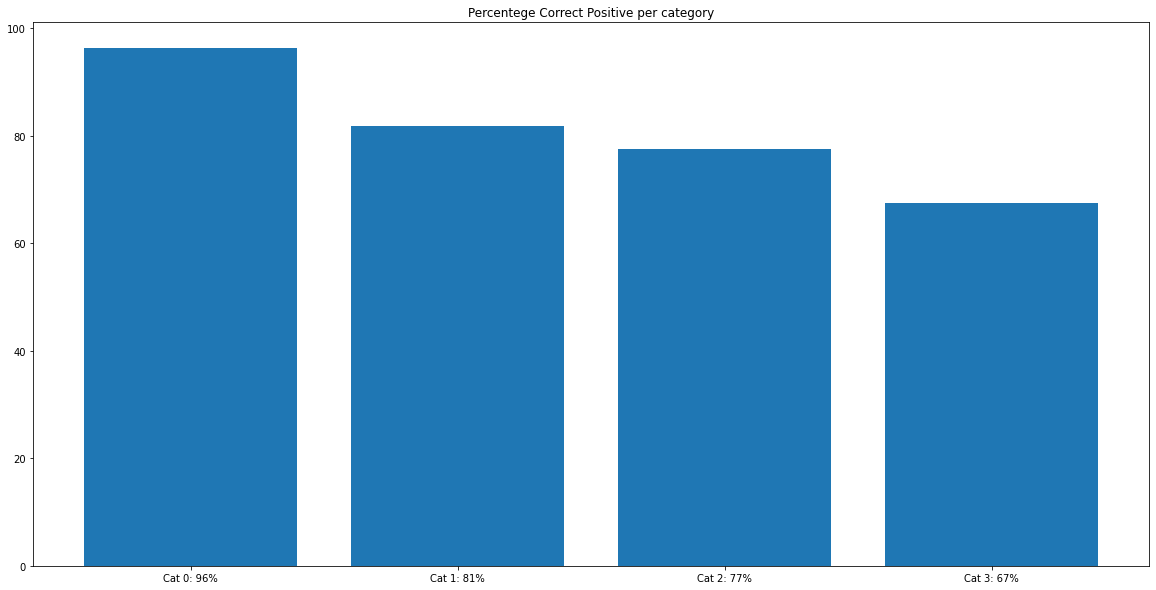

In [135]:
predict = model.predict(x_test)
nr_correct = np.zeros(4)
nr_wrong = np.zeros(4)
for (index, p) in enumerate(predict):
  p_category = np.where(p == np.max(p))[0][0]
  e_category = np.where(y_test[index] == np.max(y_test[index]))[0][0]
  if p_category == e_category:
    nr_correct[e_category] = nr_correct[e_category]+ 1
  else:
    nr_wrong[e_category] = nr_wrong[e_category] + 1
print("Total tested {}".format(len(predict)))
plt.figure(1, figsize=(20, 10))
plt.bar(["Cat " + str(j) + ": " + str(int(nr_correct[j] / (nr_correct[j] + nr_wrong[j])* 100)) + "%" for j in range(4)], nr_correct / (nr_correct + nr_wrong) * 100)
plt.title("Percentege Correct Positive per category")
plt.show()


## Saving Model to JSON

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(current_model_path + "model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(current_model_path + "model.h5")
print("Saved model to disk")

# Convert Model to ONNX

In [136]:
onnx_model = keras2onnx.convert_keras(model)
keras2onnx.save_model(onnx_model, current_model_path + "model.onnx")

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 12 -> 7


## Finish